# CNC compression task
Toy SNN net to test minimum necessary for compresson.<br /> 
The econder part of this network is based on the CNC classification task<br /> 
This repo depends on snntorch and the CNC machining dataset from Bosch:<br /> 
Paper https://doi.org/10.1016/j.procir.2022.04.022<br /> 
Repo for the dataset https://github.com/boschresearch/CNC_Machining<br /> 
Once downloaded, put the dataset folder in the same folder of CNC_toy.<br /> 

In [1]:
import os, torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import snntorch as snn
import snntorch.functional as SF
from snntorch import spikeplot as splt
from Datasets.CNC_Machining.utils import data_loader_utils
import matplotlib.pyplot as plt
from snntorch import surrogate

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# device = torch.device("cpu")
device_name = torch.cuda.get_device_name(device)

print("Torch device: " + device_name)

## if you're on M1 or M2 GPU:
# device = torch.device("mps")

Torch device: AMD Radeon RX 7800 XT


### Loading CNC dataset

In [2]:
# Defining naming schemes to load dataset files
machines = ["M01", "M02", "M03"]
process_names = [
    "OP00",
    "OP01",
    "OP02",
    "OP03",
    "OP04",
    "OP05",
    "OP06",
    "OP07",
    "OP08",
    "OP09",
    "OP10",
    "OP11",
    "OP12",
    "OP13",
    "OP14",
]
labels = ["good", "bad"]
path_to_dataset = "./Datasets/CNC_Machining/data/"  # dataset location

In [3]:
X_data = []
y_data = []
class_count = {}

dataset_max = 0
for process_name in process_names:
    for machine in machines:
        for label in labels:
            data_path = os.path.join(path_to_dataset, machine, process_name, label)
            data_list, data_label = data_loader_utils.load_tool_research_data(
                data_path, label=label
            )

            # Rectify
            for data_i, data in enumerate(data_list):
                data = data - np.mean(data, axis=0)
                data_list[data_i] = data
                if np.max(np.abs(data)) > dataset_max:
                    dataset_max = np.max(np.abs(data))

            # concatenating
            X_data.extend(data_list)
            y_data.extend(data_label)

n_recs = len(y_data)

cnc_data_info_type = [
    ("machine", "U3"),
    ("process", "U4"),
    ("class", "U4"),
    ("rec_date", "U10"),
    ("idx", "U4"),
    ("n_samples", np.int32),
]
cnc_data_info = np.zeros(n_recs, dtype=cnc_data_info_type)

for label_i, label in enumerate(y_data):
    d_machine = label[:3]
    d_process = label[13:17]
    d_class = label[22:]
    d_rec_date = label[4:12]
    d_idx = label[18:21]
    d_n_samples = len(X_data[label_i])
    cnc_data_info[label_i] = np.array(
        [(d_machine, d_process, d_class, d_rec_date, d_idx, d_n_samples)],
        dtype=cnc_data_info_type,
    )

class_count["good"] = sum(cnc_data_info["class"] == "good")
class_count["bad"] = sum(cnc_data_info["class"] == "bad")

laoding files from ./Datasets/CNC_Machining/data/M01/OP00/good... 
laoding files from ./Datasets/CNC_Machining/data/M01/OP00/bad... 
laoding files from ./Datasets/CNC_Machining/data/M02/OP00/good... 
laoding files from ./Datasets/CNC_Machining/data/M02/OP00/bad... 
laoding files from ./Datasets/CNC_Machining/data/M03/OP00/good... 
laoding files from ./Datasets/CNC_Machining/data/M03/OP00/bad... 
laoding files from ./Datasets/CNC_Machining/data/M01/OP01/good... 
laoding files from ./Datasets/CNC_Machining/data/M01/OP01/bad... 
laoding files from ./Datasets/CNC_Machining/data/M02/OP01/good... 
laoding files from ./Datasets/CNC_Machining/data/M02/OP01/bad... 
laoding files from ./Datasets/CNC_Machining/data/M03/OP01/good... 
laoding files from ./Datasets/CNC_Machining/data/M03/OP01/bad... 
laoding files from ./Datasets/CNC_Machining/data/M01/OP02/good... 
laoding files from ./Datasets/CNC_Machining/data/M01/OP02/bad... 
laoding files from ./Datasets/CNC_Machining/data/M02/OP02/good... 
la

### Plotting a single file

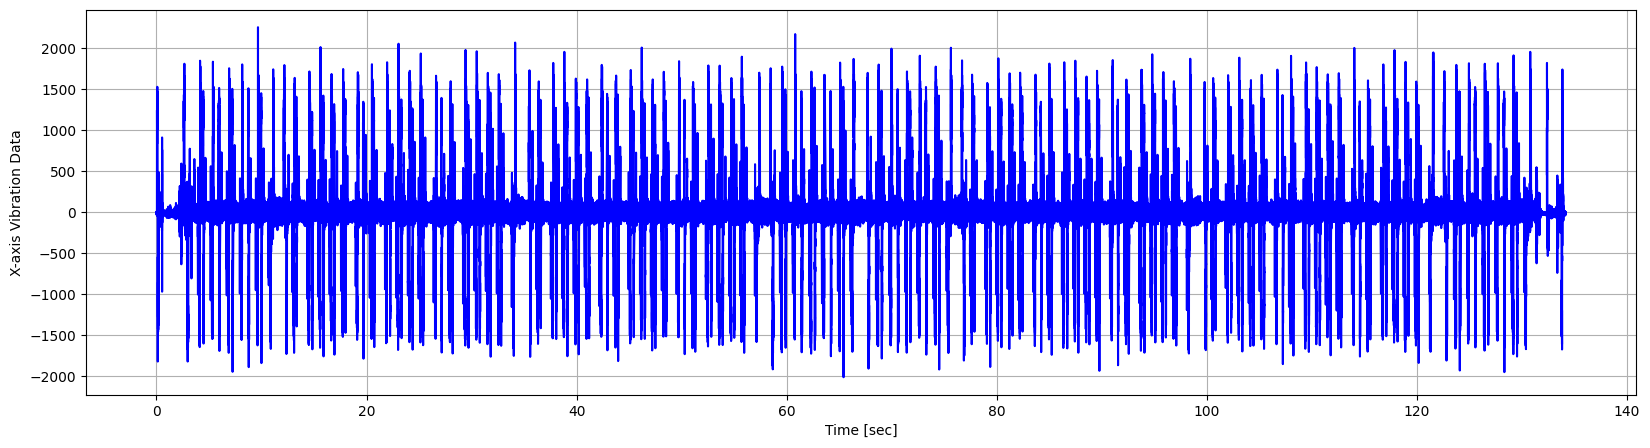

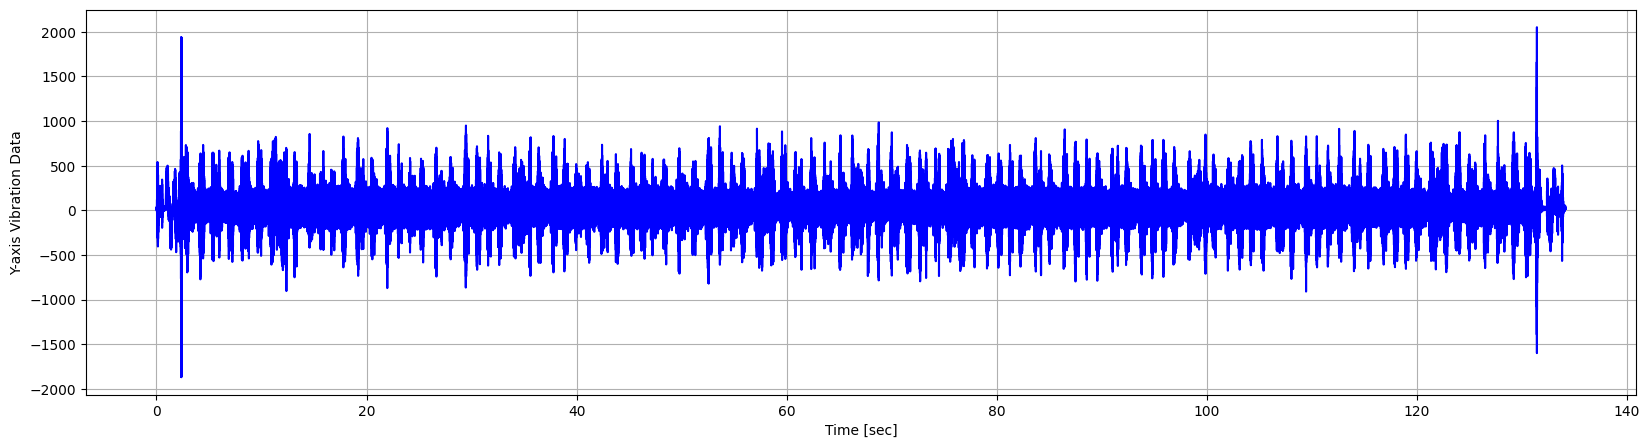

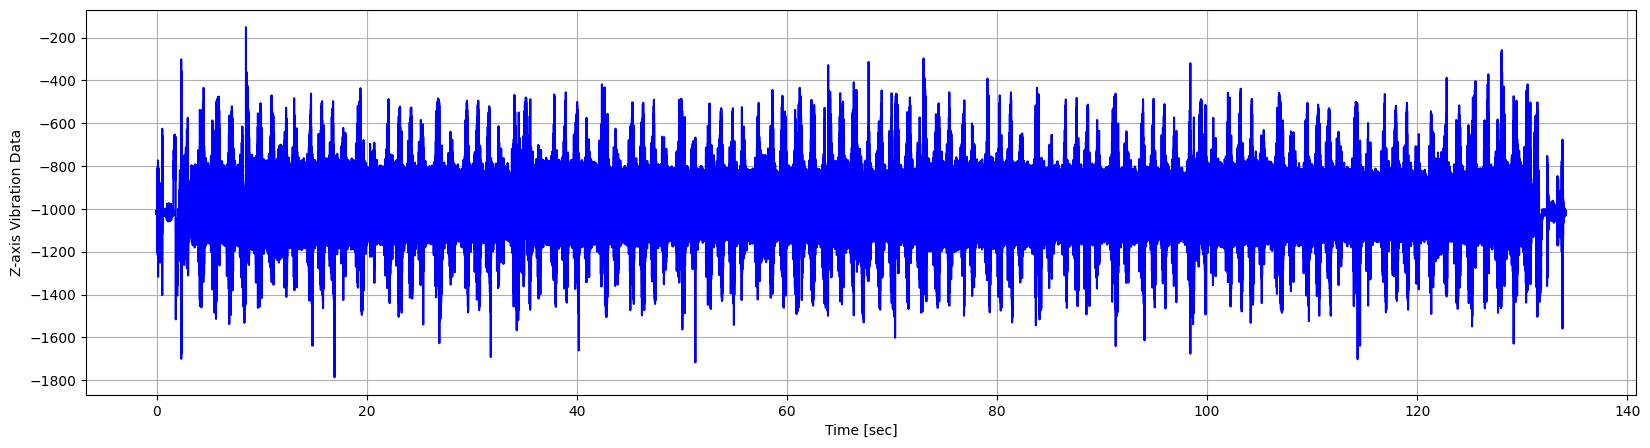

In [4]:
file = path_to_dataset + "M01/OP00/good/M01_Aug_2019_OP00_000.h5"
sample = data_loader_utils.datafile_read(file)

### Prepare dataset for snntorch

In [21]:
cut_data_l = 1000  # How many time samples we want in a single recording
n_test_batches = 30
batch_size = 2048

X_prime = []

for rec in X_data:
    n_sub_recs = len(rec) // cut_data_l
    for sub_rec_i in range(n_sub_recs - 1):
        for axis in range(3):
            X_prime.append(
                rec[sub_rec_i * cut_data_l : (sub_rec_i + 1) * cut_data_l, axis]
            )

n_train_b = len(X_prime[: -n_test_batches * batch_size]) // batch_size
print(f"Number of batches: {n_train_b}")
data_train = np.array(X_prime[: n_train_b * batch_size])
np.random.shuffle(data_train)
data_train = np.reshape(data_train, [n_train_b, batch_size, cut_data_l])
data_train = torch.tensor(data_train, dtype=dtype, device=device)

# Normalize data
data_train = data_train / (data_train.abs().max())
data_train = data_train - data_train.min()
mean_data = data_train.mean().cpu().detach().numpy()

Number of batches: 228


#### Sim Parameters 

Let's define the Autoencoder parameters.

In [32]:
# Network Architecture/Parameters

# Encoder
n_inputs_en = 1
n_hidden_en = 30
# TODO set beta values automatically from freq analysis of data signal.
hid_beta_en = np.logspace(np.log10(0.1), np.log10(0.9), num=n_hidden_en, base=10)
hid_beta_en = torch.tensor(hid_beta_en, dtype=dtype)
hid_thresh_en = mean_data * 1.2
n_latent_en = 4
latent_beta_en = 0.99
latent_thresh = 0.5

# Decoder
input_beta_de = 0.1
n_hidden_1_de = 30
n_hidden_2_de = 30
n_outputs_de = n_inputs_en

Hidden layer betas act as a frequency decomposition of the input signal, since it defines the response of an RC circuit (the neuron).
Let's do some math to see the actual cutoff frequencies of those betas.

In [7]:
sample_period = 0.5
sample_period_seconds = sample_period * 1e-3
taus = -sample_period_seconds / np.log(hid_beta_en)
freqs = 1 / (np.pi * 2 * taus)

print("Hidden Layer Betas in simulation time")
print(hid_beta_en)
print("Hidden Layer Taus in Seconds")
print(taus)
print("Cut-Off Frequencies HZ")
print(freqs)

Hidden Layer Betas in simulation time
tensor([0.1000, 0.1079, 0.1164, 0.1255, 0.1354, 0.1461, 0.1576, 0.1700, 0.1833,
        0.1978, 0.2133, 0.2301, 0.2482, 0.2678, 0.2888, 0.3116, 0.3361, 0.3626,
        0.3911, 0.4219, 0.4551, 0.4909, 0.5296, 0.5712, 0.6162, 0.6647, 0.7170,
        0.7735, 0.8343, 0.9000])
Hidden Layer Taus in Seconds
tensor([0.0002, 0.0002, 0.0002, 0.0002, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
        0.0003, 0.0003, 0.0003, 0.0004, 0.0004, 0.0004, 0.0004, 0.0005, 0.0005,
        0.0005, 0.0006, 0.0006, 0.0007, 0.0008, 0.0009, 0.0010, 0.0012, 0.0015,
        0.0019, 0.0028, 0.0047])
Cut-Off Frequencies HZ
tensor([732.9355, 708.8184, 684.7012, 660.5840, 636.4669, 612.3497, 588.2325,
        564.1152, 539.9981, 515.8809, 491.7637, 467.6465, 443.5294, 419.4122,
        395.2950, 371.1778, 347.0607, 322.9435, 298.8263, 274.7091, 250.5919,
        226.4747, 202.3576, 178.2404, 154.1232, 130.0060, 105.8888,  81.7716,
         57.6545,  33.5373])


In [33]:
# Define Network
class Net(nn.Module):
    def __init__(self, spike_grad):
        super().__init__()

        # Initialize layers
        # Encoder
        self.lin_1_en = nn.Linear(n_inputs_en, n_hidden_en, bias=False)
        self.lin_1_en.weight.data = torch.ones(self.lin_1_en.weight.size())
        self.lif_1_en = snn.Leaky(
            beta=hid_beta_en,
            threshold=hid_thresh_en,
            spike_grad=spike_grad,
            reset_mechanism="zero",
        )
        self.lin_2_en = nn.Linear(n_hidden_en, n_latent_en, bias=False)
        self.lin_2_en.weight.data = self.lin_2_en.weight.data + 0.1
        self.lif_2_en = snn.Leaky(
            beta=latent_beta_en,
            threshold=latent_thresh,
            spike_grad=spike_grad,
            reset_mechanism="zero",
        )

        # Decoder
        # self.lin_1_de = nn.Linear(n_latent_en, n_hidden_1_de, bias=False)
        # self.lif_1_de = snn.Leaky(
        #     beta=hid_beta_en,
        #     threshold=100000,
        #     spike_grad=spike_grad,
        #     reset_mechanism="zero",
        # )
        self.rnn_1_de = nn.Linear(n_latent_en + n_hidden_1_de, n_hidden_1_de)
        self.sig_1_de = nn.LeakyReLU()
        self.rnn_2_de = nn.Linear(n_hidden_1_de + n_hidden_2_de, n_hidden_2_de)
        self.sig_2_de = nn.LeakyReLU()
        self.lin_output = nn.Linear(n_hidden_2_de, n_outputs_de)
        self.relu_output = nn.LeakyReLU()

    def forward(self, input, t0=True):

        # If we are at t0,
        # initialize hidden states at t=0
        if t0:
            mem_1_en = self.lif_1_en.init_leaky()
            mem_2_en = self.lif_2_en.init_leaky()
            mem_1_de = torch.zeros(batch_size, n_hidden_1_de, device=device)
            mem_2_de = torch.zeros(batch_size, n_hidden_2_de, device=device)

        # Record the last layer
        rec_out = []

        # Also part of the network states for debug
        en_hid_spikes = []
        en_hid_mem = []
        latent_spikes = []
        latent_mem = []

        num_steps = len(input)

        for step in range(num_steps):
            # Encoder
            sum1_en = self.lin_1_en(input[step][:, None])
            spk_1_en, mem_1_en = self.lif_1_en(sum1_en, mem_1_en)
            sum2_en = self.lin_2_en(spk_1_en)
            spk_2_en, mem_2_en = self.lif_2_en(sum2_en, mem_2_en)
            # Decoder
            rnn_input = torch.cat((spk_2_en, mem_1_de), 1)
            mem_1_de = self.rnn_1_de(rnn_input)
            mem_1_de = self.sig_2_de(mem_1_de)
            rnn_input = torch.cat((mem_1_de, mem_2_de), 1)
            mem_2_de = self.rnn_2_de(rnn_input)
            mem_2_de = self.sig_2_de(mem_2_de)
            sum_out = self.lin_output(mem_2_de)
            mem_out = self.relu_output(sum_out)

            # Out Lists
            rec_out.append(mem_out)
            en_hid_spikes.append(spk_1_en)
            en_hid_mem.append(mem_1_en)
            latent_spikes.append(spk_2_en)
            latent_mem.append(mem_2_en)

        return (
            torch.stack(rec_out, dim=0),
            [
                torch.stack(en_hid_spikes, dim=0),
                torch.stack(en_hid_mem, dim=0),
                torch.stack(latent_spikes, dim=0),
                torch.stack(latent_mem, dim=0),
            ],
        )


# The smoothest sigmoid avoids gradient to be zero too far from spike
spike_grad = surrogate.fast_sigmoid(slope=25)
# spike_grad = surrogate.sigmoid(slope=25)

# Load the network onto CUDA if available
net = Net(spike_grad).to(device)

### Run network

In [37]:
loss = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4)
# optimizer = torch.optim.SGD(net.parameters(), lr=2e-5)

# Rest of points are needed to reach steady state
begin_recording = 0

# Outer training loop
num_epochs = 100
loss_hist = []

# Outer training loop
for epoch in range(num_epochs):
    for batch_i in range(n_train_b):
        # forward pass
        net.train()
        mem_out, hid_monitor = net(torch.swapaxes(data_train[batch_i], 0, 1))
        loss_val = loss(
            mem_out[begin_recording:],
            torch.swapaxes(data_train[batch_i, :, begin_recording:], 0, 1)[:, :, None],
        )

        [en_hid_spikes, en_hid_mem, latent_spikes, latent_mem] = hid_monitor

        sum_en_hid_spikes = np.sum(en_hid_spikes.cpu().detach().numpy(), axis=0)
        sum_latent_spikes = np.sum(latent_spikes.cpu().detach().numpy(), axis=0)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Print train/test loss/accuracy
        print(
            f"Iteration: {epoch} \t Batch: {batch_i} \t Train Loss: {loss_val.item()}"
        )
        print(f"Total hidden spikes: {sum_en_hid_spikes}")
        print(f"Total latent spikes: {sum_latent_spikes}")

Iteration: 0 	 Batch: 0 	 Train Loss: 0.0003082251059822738
Total hidden spikes: [[294. 215. 296. ... 338. 337. 333.]
 [281. 153. 290. ... 333. 333. 333.]
 [278. 180. 281. ... 337. 334. 333.]
 ...
 [264. 197. 274. ... 334. 333. 333.]
 [329. 207. 329. ... 333. 333. 333.]
 [325. 196. 325. ... 334. 334. 333.]]
Total latent spikes: [[339. 201. 268.  10.]
 [367. 136. 249.   0.]
 [339. 156. 268.  18.]
 ...
 [345. 155. 248.   6.]
 [349. 185. 282.   0.]
 [372. 167. 274.  27.]]


In [27]:
net.lin_1_en.weight.data

tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan]], device='cuda:0')

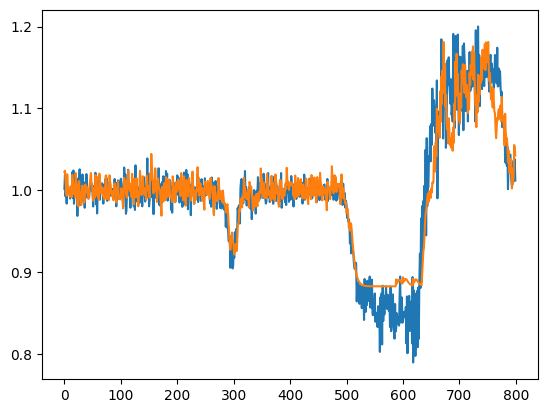

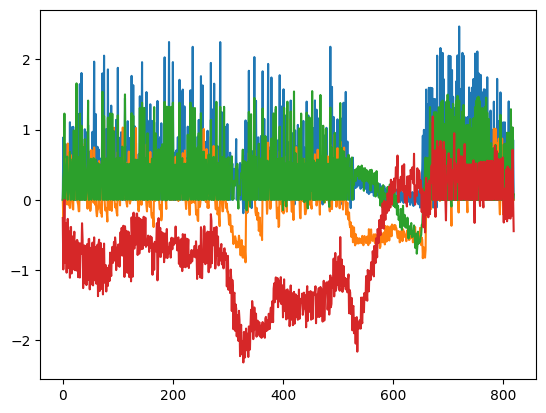

In [59]:
batch_i = 0
rec_i = 190
begin_recording = 200

plt.figure()
plt.plot(data_train.cpu().detach()[batch_i, rec_i, begin_recording:])

# plt.figure()
plt.plot(mem_out.cpu().detach()[begin_recording:, rec_i, 0])

plt.figure()
plt.plot(latent_mem.cpu().detach()[180:, rec_i, :])

# plt.figure()
# plt.plot(en_hid_mem.cpu().detach()[180:,:,0])